# Aggregate AP1 footprint in non-fibroblast peaks (using scATAC-seq)

Footprint of AP1 at non-fibroblast D2 sites. Assisted by bias model.

Similar to `AP1_transient_Footprint.ipynb`, which was done with multiome data. Also predicting the model predicted footprint.

Also doing it for fibroblast cells to contrast.

In [1]:
import pyBigWig
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import tensorflow as tf
import seaborn as sns
import pyfaidx
import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
import utils
from utils import one_hot
from utils.data_utils import get_seq
from collections import Counter
# for some seaborn warnings
import warnings; warnings.simplefilter('ignore')
from utils.loss import multinomial_nll
from metrics import softmax
import time

/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/surag/anaconda3/envs/mtbatc

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    xOSK_bias_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.adjusted_bias_model.h5")
    xOSK_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.h5")
    
    fibr_bias_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.adjusted_bias_model.h5")
    fibr_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
HEADER = ['chr', 'start', 'end', 'strand', 'score', 'seq', 'imp']

In [6]:
ap1_not_fibr = pd.read_csv("./AP1.not.fibr.bed", 
                           sep='\t',
                          names=HEADER)
ap1_not_fibr.head()

,chr,start,end,strand,score,seq,imp
0,chr17,46474674,46474683,+,8.923917,GTGAGTCATG,0.577262
1,chr17,70057186,70057195,+,8.479893,ATGACTCAAC,0.323845
2,chr17,19642881,19642890,-,7.221008,GATTAGTCAC,0.311039
3,chr13,32056511,32056520,+,6.278644,ATGACACATT,0.274024
4,chr13,58087773,58087782,-,9.478803,AATGAGTCAG,0.706478


In [7]:
print(ap1_not_fibr.shape)

(10773, 7)


In [8]:
def get_vals(bw_file, regs, w=2000):
    vals = []
    bw = pyBigWig.open(bw_file)
    
    motif_half_len = (regs.iloc[0]['end'] - regs.iloc[0]['start'])//2
    
    for _, x in tqdm(regs.iterrows(), total=regs.shape[0]):
        if x['strand'] == "+":
            vals.append(np.nan_to_num(bw.values(x['chr'], x['start']+motif_half_len-w//2, x['start']+motif_half_len+w//2)))
        else:
            vals.append(np.nan_to_num(bw.values(x['chr'], x['end']-motif_half_len-w//2, x['end']-motif_half_len+w//2))[::-1])
    
    bw.close()
    
    return np.array(vals)

In [9]:
def get_seq(regs, w=2000):
    seqs = []
    motif_half_len = (regs.iloc[0]['end'] - regs.iloc[0]['start'])//2
    
    with pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta") as hg38:            
        for _, x in tqdm(regs.iterrows(), total=regs.shape[0]):
            if x['strand'] == "+":
                cur = str(hg38[x['chr']][x['start']+motif_half_len-w//2: x['start']+motif_half_len+w//2])
                seqs.append(one_hot.dna_to_one_hot([cur])[0])
            else:
                cur = str(hg38[x['chr']][x['end']-motif_half_len-w//2: x['end']-motif_half_len+w//2])
                seqs.append(one_hot.dna_to_one_hot([cur])[0][::-1, ::-1])
    
    return np.array(seqs)

In [10]:
seqs = get_seq(ap1_not_fibr)

100%|██████████| 10773/10773 [00:42<00:00, 251.48it/s] 


In [11]:
xOSK_bias_pred_prof, xOSK_bias_pred_cts = xOSK_bias_model.predict(seqs, verbose=True)

10773/10773 [==============================] - 17s 2ms/sample


In [12]:
xOSK_pred_prof, xOSK_pred_cts = xOSK_model.predict([seqs, xOSK_bias_pred_prof, xOSK_bias_pred_cts], 
                                                   verbose=True)

10773/10773 [==============================] - 15s 1ms/sample


In [13]:
fibr_bias_pred_prof, fibr_bias_pred_cts = fibr_bias_model.predict(seqs, verbose=True)

10773/10773 [==============================] - 14s 1ms/sample


In [14]:
fibr_pred_prof, fibr_pred_cts = xOSK_model.predict([seqs, fibr_bias_pred_prof, fibr_bias_pred_cts], 
                                                   verbose=True)

10773/10773 [==============================] - 14s 1ms/sample


In [46]:
xOSK_c11 = get_vals("/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw",
                   ap1_not_fibr,
                   w=2000)

100%|██████████| 10773/10773 [00:11<00:00, 905.39it/s] 


In [16]:
fibr_c1 = get_vals("/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw",
                   ap1_not_fibr,
                   w=2000)

100%|██████████| 10773/10773 [01:00<00:00, 177.18it/s] 


In [48]:
# from number of lines in tagAlign files
xOSK_c11_DEPTH = 67544062
FIBR_c1_DEPTH = 405673952

In [52]:
xOSK_c11_null = np.sum((softmax(xOSK_bias_pred_prof).T * (xOSK_c11.sum(-1))).T, 0)
xOSK_c11_null = xOSK_c11_null/xOSK_c11_null.sum()

In [22]:
fibr_c1_null = np.sum((softmax(fibr_bias_pred_prof).T * (fibr_c1.sum(-1))).T, 0)
fibr_c1_null = fibr_c1_null/fibr_c1_null.sum()

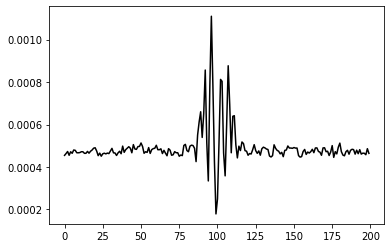

In [54]:
plt.plot(xOSK_c11_null[900:1100], c='k')

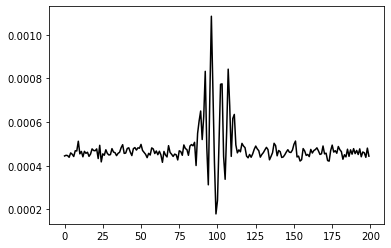

In [30]:
plt.plot(fibr_c1_null[900:1100], c='k')

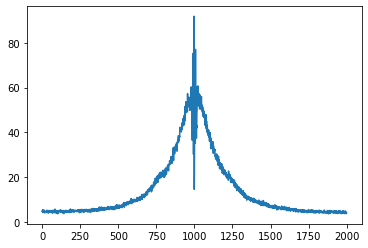

In [56]:
plt.plot(xOSK_c11.sum(0)/xOSK_c11_DEPTH*1e6)

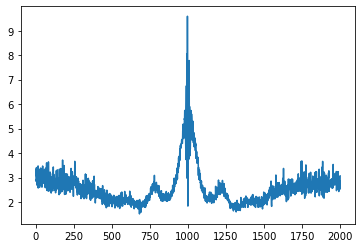

In [57]:
plt.plot(fibr_c1.sum(0)/FIBR_c1_DEPTH*1e6)

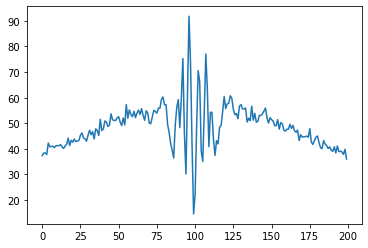

In [58]:
plt.plot((xOSK_c11.sum(0)/xOSK_c11_DEPTH*1e6)[900:1100])

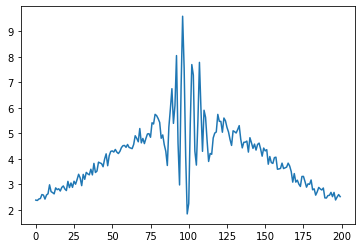

In [59]:
plt.plot((fibr_c1.sum(0)/FIBR_c1_DEPTH*1e6)[900:1100])

In [63]:
xOSK_c11_corr = (xOSK_c11.sum(0)/xOSK_c11_DEPTH*1e6)/xOSK_c11_null

In [64]:
fibr_c1_corr = (fibr_c1.sum(0)/FIBR_c1_DEPTH*1e6)/fibr_c1_null

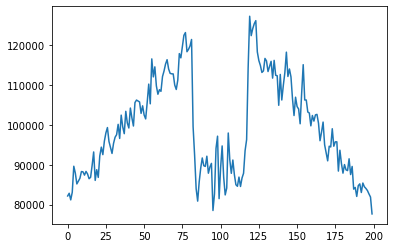

In [66]:
plt.plot(xOSK_c11_corr[900:1100])

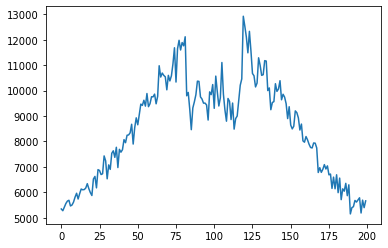

In [67]:
plt.plot(fibr_c1_corr[900:1100])

In [70]:
xOSK_predicted_corr = ((softmax(xOSK_pred_prof).T * (xOSK_c11.sum(-1)).T).sum(1)/xOSK_c11_DEPTH*1e6)/xOSK_c11_null

In [71]:
fibr_predicted_corr = ((softmax(fibr_pred_prof).T * (fibr_c1.sum(-1)).T).sum(1)/FIBR_c1_DEPTH*1e6)/fibr_c1_null

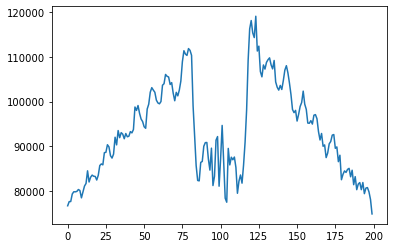

In [72]:
plt.plot(xOSK_predicted_corr[900:1100])

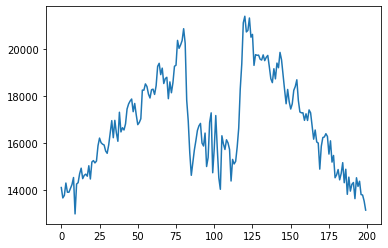

In [73]:
plt.plot(fibr_predicted_corr[900:1100])

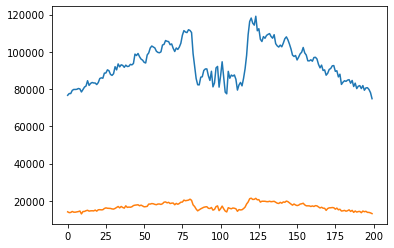

In [74]:
plt.plot(xOSK_predicted_corr[900:1100])
plt.plot(fibr_predicted_corr[900:1100])

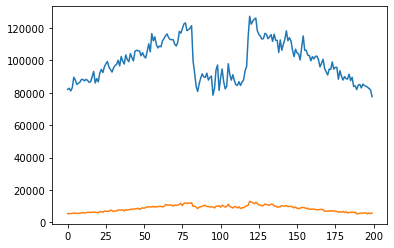

In [75]:
plt.plot(xOSK_c11_corr[900:1100])
plt.plot(fibr_c1_corr[900:1100])

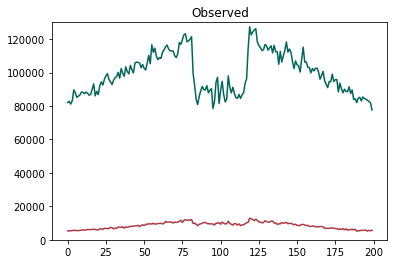

In [84]:
plt.plot(xOSK_c11_corr[900:1100], c='#006658')
plt.plot(fibr_c1_corr[900:1100], c='#B03743')
plt.title("Observed")
plt.ylim(0, 130000)
plt.savefig("./subfigs/xOSK.and.fibr.scATAC.AP1.footprint.pdf")

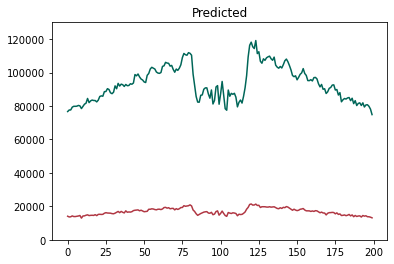

In [85]:
plt.plot(xOSK_predicted_corr[900:1100], c='#006658')
plt.plot(fibr_predicted_corr[900:1100], c='#B03743')
plt.title("Predicted")
plt.ylim(0, 130000)
plt.savefig("./subfigs/xOSK.and.fibr.scATAC.predicted.AP1.footprint.pdf")